# Applying Naive Bayes on Donors Choose Dataset

In this task we will be applying Naive Bayes classifier on Donors Choose Dataset. DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.

The goal of the task is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. We will be applying two encoding techniques BoW and IDF on the essay feature and compare their results. We have already performed EDA on this dataset and are using a cleaned preprocessed file for this task.

## 1.1 Loading Data
Importing the data into a python dataframe and removing the class label column 'project_is_approved' from the feature set x.

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

import pickle
from tqdm import tqdm
import os

from collections import Counter

In [3]:
import pandas
data = pandas.read_csv('C:\\Users\\rishabhs\\Documents\\Assignment 8 - Naive Bayes\\preprocessed_data.csv',nrows=50000)
data.head()

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,project_is_approved,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,1,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,1,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,1,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,1,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,1,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74


In [4]:
y = data['project_is_approved'].values
x = data.drop(['project_is_approved'],axis = 1)
x

,school_state,teacher_prefix,project_grade_category,teacher_number_of_previously_posted_projects,clean_categories,clean_subcategories,essay,price
0,ca,mrs,grades_prek_2,53,math_science,appliedsciences health_lifescience,i fortunate enough use fairy tale stem kits cl...,725.05
1,ut,ms,grades_3_5,4,specialneeds,specialneeds,imagine 8 9 years old you third grade classroo...,213.03
2,ca,mrs,grades_prek_2,10,literacy_language,literacy,having class 24 students comes diverse learner...,329.00
3,ga,mrs,grades_prek_2,2,appliedlearning,earlydevelopment,i recently read article giving students choice...,481.04
4,wa,mrs,grades_3_5,2,literacy_language,literacy,my students crave challenge eat obstacles brea...,17.74
...,...,...,...,...,...,...,...,...
49995,ky,mrs,grades_3_5,0,math_science,mathematics,my students selfless group students i ever met...,150.92
49996,md,mrs,grades_3_5,3,math_science specialneeds,mathematics specialneeds,my third grade math students defying odds balt...,19.74
49997,id,mrs,grades_prek_2,1,literacy_language math_science,literacy mathematics,my kindergartners active little ones love lear...,64.98
49998,fl,mrs,grades_3_5,0,literacy_language,literature_writing,i privileged teach dynamic group fourth grader...,6.60


<h2>1.2 Splitting data into Train and cross validation(or test): Stratified Sampling</h2>

In [6]:
 from sklearn.model_selection import train_test_split
    
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size = 0.33,stratify = y)  #splitting x data into train and test dataset
X_train,x_cv,y_train,y_cv = train_test_split(x_train,y_train, test_size = 0.33,stratify = y_train) #splitting x_train into train and cross validation datasets as we would be using for loop for Naive Bayes implementaion

<h2>Make Data Model Ready:</h2>

<ol>
    <strong>We will be applying Naive Bayes on the following feature sets.</strong>
        <ul>
                <dl>
                  <dt>Text Features:</dt>
                  <dd> - essay</dd>
                  <dt>Categorical Features:</dt>
                  <dd> - teacher_prefix</dd>
                  <dd> - project_grade_category</dd>
                  <dd> - school_state</dd>
                  <dd> - clean_categories</dd>
                  <dd> - clean_subcategories</dd>
                  <dt>Numerical Features:</dt>
                  <dd> - price</dd>
                  <dd> - teacher_number_of_previously_posted_projects</dd>
                </dl>    
            <li><font color='red'>Set 1</font>: categorical, numerical features + preprocessed_eassay (BOW)</li>
            <li><font color='red'>Set 2</font>: categorical, numerical features + preprocessed_eassay (TFIDF)</li>
        </ul>

<h3>1.3 Encoding text feature: Essay</h3>

In [7]:
print(X_train.shape, y_train.shape)
print(x_cv.shape,y_cv.shape)
print(x_test.shape,y_test.shape)

vec = CountVectorizer(min_df = 4, ngram_range = (1,4),max_features=5000) #initializing vectorizer

X_train_essay_bow = vec.fit_transform(X_train['essay']) #fitting only train data and transforming all data for BOW
x_cv_essay_bow = vec.transform(x_cv['essay'])
x_test_essay_bow = vec.transform(x_test['essay'])

print('-' *100)
print('After Vectorization')
print(X_train_essay_bow.shape,y_train.shape)
print(x_cv_essay_bow.shape,y_cv.shape)
print(x_test_essay_bow.shape,y_test.shape)

(22445, 8) (22445,)
(11055, 8) (11055,)
(16500, 8) (16500,)
----------------------------------------------------------------------------------------------------
After Vectorization
(22445, 5000) (22445,)
(11055, 5000) (11055,)
(16500, 5000) (16500,)


In [8]:
idf_vec = TfidfVectorizer(min_df = 4, ngram_range = (1,4),max_features=5000) #initializing IDF vectorizer
idf_vec.fit(X_train['essay'])                                                #fitting the train data

X_train_essay_idf = idf_vec.transform(X_train['essay'])                     #getting idf for train,test and cv data
x_cv_essay_idf = idf_vec.transform(x_cv['essay'])
x_test_essay_idf = idf_vec.transform(x_test['essay'])

print('-' *100)
print('After IDF Vectorization')
print(X_train_essay_idf.shape,y_train.shape)
print(x_cv_essay_idf.shape,y_cv.shape)
print(x_test_essay_idf.shape,y_test.shape)

----------------------------------------------------------------------------------------------------
After IDF Vectorization
(22445, 5000) (22445,)
(11055, 5000) (11055,)
(16500, 5000) (16500,)


<h2>1.4 Encoding Numerical, Categorical Features</h2>

<h3>1.4.1 Encoding categorical features: school_state</h3>

In [9]:
vec = CountVectorizer()
X_train_state_ohe = vec.fit_transform(X_train['school_state'])
x_cv_state_ohe = vec.transform(x_cv['school_state'])
x_test_state_ohe = vec.transform(x_test['school_state'])

print(X_train_state_ohe.shape,y_train.shape)
print(x_cv_state_ohe.shape,y_cv.shape)
print(x_test_state_ohe.shape,y_test.shape)
print(vec.get_feature_names())
print('_' *127)

(22445, 51) (22445,)
(11055, 51) (11055,)
(16500, 51) (16500,)
['ak', 'al', 'ar', 'az', 'ca', 'co', 'ct', 'dc', 'de', 'fl', 'ga', 'hi', 'ia', 'id', 'il', 'in', 'ks', 'ky', 'la', 'ma', 'md', 'me', 'mi', 'mn', 'mo', 'ms', 'mt', 'nc', 'nd', 'ne', 'nh', 'nj', 'nm', 'nv', 'ny', 'oh', 'ok', 'or', 'pa', 'ri', 'sc', 'sd', 'tn', 'tx', 'ut', 'va', 'vt', 'wa', 'wi', 'wv', 'wy']
_______________________________________________________________________________________________________________________________


<h3>1.4.2 Encoding categorical features: teacher_prefix</h3>

In [172]:
vec = CountVectorizer()
X_train_teacher_pre_ohe = vec.fit_transform(X_train['teacher_prefix'])
x_cv_teacher_pre_ohe = vec.transform(x_cv['teacher_prefix'])
x_test_teacher_pre_ohe = vec.transform(x_test['teacher_prefix'])

print(X_train_teacher_pre_ohe.shape,y_train.shape)
print(x_cv_teacher_pre_ohe.shape,y_cv.shape)
print(x_test_teacher_pre_ohe.shape,y_test.shape)
print(vec.get_feature_names())
print('_' *127)

(22445, 5) (22445,)
(11055, 5) (11055,)
(16500, 5) (16500,)
['dr', 'mr', 'mrs', 'ms', 'teacher']
_______________________________________________________________________________________________________________________________


<h3>1.4.3 Encoding categorical features: project_grade_category</h3>

In [11]:
vec = CountVectorizer()
X_train_project_grade_ohe = vec.fit_transform(X_train['project_grade_category'])
x_cv_project_grade_ohe = vec.transform(x_cv['project_grade_category'])
x_test_project_grade_ohe = vec.transform(x_test['project_grade_category'])

print(X_train_project_grade_ohe.shape,y_train.shape)
print(x_cv_project_grade_ohe.shape,y_cv.shape)
print(x_test_project_grade_ohe.shape,y_test.shape)
print(vec.get_feature_names())
print('_' *127)

(22445, 4) (22445,)
(11055, 4) (11055,)
(16500, 4) (16500,)
['grades_3_5', 'grades_6_8', 'grades_9_12', 'grades_prek_2']
_______________________________________________________________________________________________________________________________


<h3>1.4.4 Encoding categorical features: clean_categories</h3>

In [173]:
vec = CountVectorizer()
X_train_clean_categories_ohe = vec.fit_transform(X_train['clean_categories'])
x_cv_clean_categories_ohe = vec.transform(x_cv['clean_categories'])
x_test_clean_categories_ohe = vec.transform(x_test['clean_categories'])

print(X_train_clean_categories_ohe.shape,y_train.shape)
print(x_cv_clean_categories_ohe.shape,y_cv.shape)
print(x_test_clean_categories_ohe.shape,y_test.shape)
print(vec.get_feature_names())
print('_' *127)

(22445, 9) (22445,)
(11055, 9) (11055,)
(16500, 9) (16500,)
['appliedlearning', 'care_hunger', 'health_sports', 'history_civics', 'literacy_language', 'math_science', 'music_arts', 'specialneeds', 'warmth']
_______________________________________________________________________________________________________________________________


<h3>1.4.5 Encoding categorical features: clean_subcategories</h3>

In [174]:
vec = CountVectorizer()
X_train_clean_subcategories_ohe = vec.fit_transform(X_train['clean_subcategories'])
x_cv_clean_subcategories_ohe = vec.transform(x_cv['clean_subcategories'])
x_test_clean_subcategories_ohe = vec.transform(x_test['clean_subcategories'])

print(X_train_clean_subcategories_ohe.shape,y_train.shape)
print(x_cv_clean_subcategories_ohe.shape,y_cv.shape)
print(x_test_clean_subcategories_ohe.shape,y_test.shape)
print(vec.get_feature_names())
print('_' *127)

(22445, 30) (22445,)
(11055, 30) (11055,)
(16500, 30) (16500,)
['appliedsciences', 'care_hunger', 'charactereducation', 'civics_government', 'college_careerprep', 'communityservice', 'earlydevelopment', 'economics', 'environmentalscience', 'esl', 'extracurricular', 'financialliteracy', 'foreignlanguages', 'gym_fitness', 'health_lifescience', 'health_wellness', 'history_geography', 'literacy', 'literature_writing', 'mathematics', 'music', 'nutritioneducation', 'other', 'parentinvolvement', 'performingarts', 'socialsciences', 'specialneeds', 'teamsports', 'visualarts', 'warmth']
_______________________________________________________________________________________________________________________________


<h3>1.4.6 Encoding numerical features: teacher_number_of_previously_posted_projects</h3>

In [14]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()

X_train_prev_proj = normalizer.fit_transform(X_train['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
x_cv_prev_proj = normalizer.transform(x_cv['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))
x_test_prev_proj = normalizer.transform(x_test['teacher_number_of_previously_posted_projects'].values.reshape(1,-1))

X_train_prev_proj = X_train_prev_proj.reshape(-1,1)
x_cv_prev_proj = x_cv_prev_proj.reshape(-1,1)
x_test_prev_proj = x_test_prev_proj.reshape(-1,1)

print("After Normalization")
print(X_train_prev_proj.shape,y_train.shape)
print(x_cv_prev_proj.shape,y_cv.shape)
print(x_test_prev_proj.shape,y_test.shape)
print('_' *127)

After Normalization
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)
_______________________________________________________________________________________________________________________________


<h3>1.4.7 Encoding numerical features: price</h3>

In [15]:
from sklearn.preprocessing import Normalizer
normalizer = Normalizer()
# normalizer.fit(X_train['price'].values.reshape(-1,1))

X_train_norm_price = normalizer.fit_transform(X_train['price'].values.reshape(1,-1)) #Reshaping the array to 2D array for transforming it
x_cv_norm_price = normalizer.transform(x_cv['price'].values.reshape(1,-1))
x_test_norm_price = normalizer.transform(x_test['price'].values.reshape(1,-1))

X_train_norm_price = X_train_norm_price.reshape(-1,1) #reshaping it to row*col format
x_cv_norm_price = x_cv_norm_price.reshape(-1,1)
x_test_norm_price = x_test_norm_price.reshape(-1,1)

print("After Normalization")
print(X_train_norm_price.shape,y_train.shape)
print(x_cv_norm_price.shape,y_cv.shape)
print(x_test_norm_price.shape,y_test.shape)
print('_' *127)

After Normalization
(22445, 1) (22445,)
(11055, 1) (11055,)
(16500, 1) (16500,)
_______________________________________________________________________________________________________________________________


### 1.4.8 Concatinating all the features

In [175]:
from scipy.sparse import hstack

#Concatenating set1 BOW
X_tr = hstack((X_train_essay_bow, X_train_state_ohe, X_train_teacher_pre_ohe, X_train_project_grade_ohe, X_train_clean_categories_ohe,X_train_clean_subcategories_ohe,X_train_prev_proj,X_train_norm_price)).tocsr()
X_cr = hstack((x_cv_essay_bow, x_cv_state_ohe, x_cv_teacher_pre_ohe, x_cv_project_grade_ohe, x_cv_clean_categories_ohe,x_cv_clean_subcategories_ohe,x_cv_prev_proj,x_cv_norm_price)).tocsr()
X_te = hstack((x_test_essay_bow, x_test_state_ohe, x_test_teacher_pre_ohe, x_test_project_grade_ohe, x_test_clean_categories_ohe,x_test_clean_subcategories_ohe,x_test_prev_proj,x_test_norm_price)).tocsr()

#Concatenating set2 IDF
X_tr_set2 = hstack((X_train_essay_idf, X_train_state_ohe, X_train_teacher_pre_ohe, X_train_project_grade_ohe, X_train_clean_categories_ohe,X_train_clean_subcategories_ohe,X_train_prev_proj,X_train_norm_price)).tocsr()
X_cr_set2 = hstack((x_cv_essay_idf, x_cv_state_ohe, x_cv_teacher_pre_ohe, x_cv_project_grade_ohe, x_cv_clean_categories_ohe,x_cv_clean_subcategories_ohe,x_cv_prev_proj,x_cv_norm_price)).tocsr()
X_te_set2 = hstack((x_test_essay_idf, x_test_state_ohe, x_test_teacher_pre_ohe, x_test_project_grade_ohe, x_test_clean_categories_ohe,x_test_clean_subcategories_ohe,x_test_prev_proj,x_test_norm_price)).tocsr()

print("Final Data matrix Set 1")
print(X_tr.shape, y_train.shape)
print(X_cr.shape, y_cv.shape)
print(X_te.shape, y_test.shape)
print("-"*127)

print("Final Data matrix Set 2")
print(X_tr_set2.shape, y_train.shape)
print(X_cr_set2.shape, y_cv.shape)
print(X_te_set2.shape, y_test.shape)
print("-"*127)

Final Data matrix Set 1
(22445, 5101) (22445,)
(11055, 5101) (11055,)
(16500, 5101) (16500,)
-------------------------------------------------------------------------------------------------------------------------------
Final Data matrix Set 2
(22445, 5101) (22445,)
(11055, 5101) (11055,)
(16500, 5101) (16500,)
-------------------------------------------------------------------------------------------------------------------------------


<h2>1.5 Appling NB on different kind of featurization</h2>

#### 1.5.1 Hyperparameter Tuning

In [17]:
def batch_pred(nb, data):                         #defining a function with classifier and data as input
    
    tr_loop = data.shape[0] - data.shape[0]%1000  #considering multiple of thousand
    y_data_prob = []
    
    for i in range(0,tr_loop,1000):               #taking 1000 values at a time
        y_data_prob.extend(nb.predict_proba(data[i:i+1000])[:,1])
        
    if data.shape[0]%1000 != 0:                   #for remaining values left after mod 1000
        y_data_prob.extend(nb.predict_proba(data[tr_loop:])[:,1])
        
    return y_data_prob                            #returning the probability scores

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  4.71it/s]


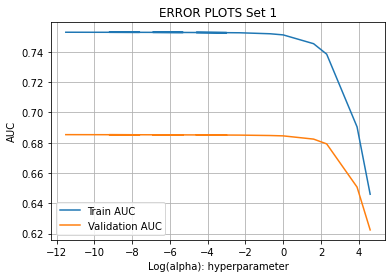

In [273]:
import matplotlib.pyplot as plt
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import roc_auc_score

tr_auc = []                                       #declaring lists for auc scores of training and cv 
cv_auc = []

alpha =  [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]

for i in tqdm(K):

    naive_bayes = MultinomialNB(alpha = i,class_prior =[0.5,0.5])
    naive_bayes.fit(X_tr,y_train)                 #fitting the training dataset in Naive Bayes classifier
    
    tr_prob = batch_pred(naive_bayes, X_tr)       #predicting probability scores using batch_pred function
    cv_prob = batch_pred(naive_bayes, X_cr)
    
    tr_auc.append(roc_auc_score(y_train,tr_prob)) #storing class label and probability scores
    cv_auc.append(roc_auc_score(y_cv,cv_prob))

log_alpha = np.log(alpha)                         #taking log(alpha) because the alpha value has a large range

plt.plot(log_alpha, tr_auc, label='Train AUC')    #plotting Train and validation AUC
plt.plot(log_alpha, cv_auc, label='Validation AUC')

plt.legend()
plt.xlabel("Log(alpha): hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS Set 1")
plt.grid()
plt.show()

100%|██████████████████████████████████████████████████████████████████████████████████| 14/14 [00:02<00:00,  5.49it/s]


[0.7359234569085416, 0.7359127140185123, 0.7359216123189073, 0.7358179463814686, 0.7359032254494343, 0.734865090403338, 0.73571236207081, 0.7338265864393149, 0.7257845297956563, 0.7162422462674729, 0.6572281572918474, 0.6156464290589273, 0.5510455502964255, 0.5406361030461553]
[0.6645975983376383, 0.6645933998399703, 0.6645963813817926, 0.664543382954708, 0.6645860981048954, 0.6641593725375659, 0.6645037710419273, 0.6637072734408513, 0.6598934555157003, 0.654816376574817, 0.6159544128340163, 0.5848973345624588, 0.5342543863652267, 0.5255544907191905]


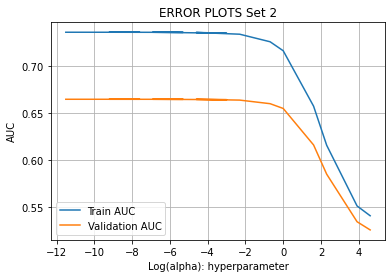

In [23]:
#Same code for set2
tr_auc_set2 = []
cv_auc_set2 = []

alpha =  [0.00001,0.0005, 0.0001,0.005,0.001,0.05,0.01,0.1,0.5,1,5,10,50,100]

for i in tqdm(K):

    naive_bayes = MultinomialNB(alpha = i,class_prior =[0.5,0.5])
    naive_bayes.fit(X_tr_set2,y_train)
    
    tr_prob_set2 = batch_pred(naive_bayes, X_tr_set2)
    cv_prob_set2 = batch_pred(naive_bayes, X_cr_set2)
    
    tr_auc_set2.append(roc_auc_score(y_train,tr_prob_set2))
    cv_auc_set2.append(roc_auc_score(y_cv,cv_prob_set2))

log_alpha = np.log(alpha)

plt.plot(log_alpha, tr_auc_set2, label='Train AUC')
plt.plot(log_alpha, cv_auc_set2, label='Validation AUC')

plt.legend()
plt.xlabel("Log(alpha): hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS Set 2")
plt.grid()
plt.show()

### 1.5.2 Testing the Model using Test Data

In [47]:
best_alpha = 1

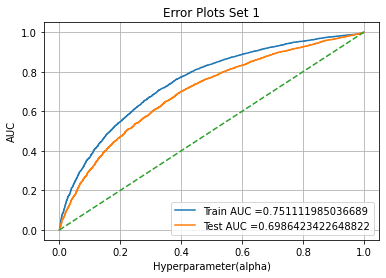

In [315]:
clf = MultinomialNB(alpha=best_alpha, class_prior=[0.5,0.5]) #initializinf NB and fitting training data
clf.fit(X_tr,y_train)

# y_pred = clf.predict(X_te)                                #storing predicted class labels which will be required for calculating Confusion Matrix

y_train_prob = batch_pred(clf,X_tr)                          #Calculating probability scores required for roc_curve
y_test_prob = batch_pred(clf,X_te)

tr_fpr, tr_tpr, tr_thres = roc_curve(y_train,y_train_prob)   #calculating tpr and fpr
te_fpr, te_tpr, te_thres = roc_curve(y_test,y_test_prob)

plt.plot(tr_fpr,tr_tpr,label='Train AUC ='+str(auc(tr_fpr,tr_tpr))) #plotting and calculating AUC
plt.plot(te_fpr,te_tpr,label='Test AUC ='+str(auc(te_fpr,te_tpr)))
plt.plot([0,1],[0,1],'--')
plt.legend()
plt.xlabel('Hyperparameter(alpha)')
plt.ylabel('AUC')
plt.grid()
plt.title('Error Plots Set 1')
plt.show()

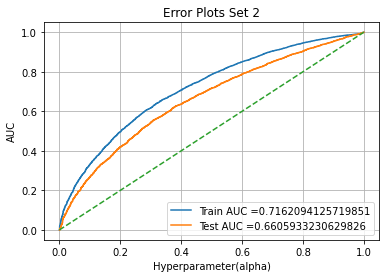

In [313]:
#Same code for set2
clf = MultinomialNB(alpha=best_alpha, class_prior=[0.5,0.5])
clf.fit(X_tr_set2,y_train)

y_train_prob_s2 = batch_pred(clf,X_tr_set2)
y_test_prob_s2 = batch_pred(clf,X_te_set2)
# y_pred_set2 = clf.predict(X_te_set2)

tr_fpr_s2, tr_tpr_s2, tr_thres_s2 = roc_curve(y_train,y_train_prob_s2)
te_fpr_s2, te_tpr_s2, te_thres_s2 = roc_curve(y_test,y_test_prob_s2)

plt.plot(tr_fpr_s2,tr_tpr_s2,label='Train AUC ='+str(auc(tr_fpr_s2,tr_tpr_s2)))
plt.plot(te_fpr_s2,te_tpr_s2,label='Test AUC ='+str(auc(te_fpr_s2,te_tpr_s2)))
plt.plot([0,1],[0,1],'--')
plt.legend()
plt.xlabel('Hyperparameter(alpha)')
plt.ylabel('AUC')
plt.grid()
plt.title('Error Plots Set 2')
plt.show()

### 1.5.3 Displaying Confusion Matrix

In [316]:
# we are writing our own function for predict, with defined threshold
# we will pick a threshold that will give the least fpr
def find_best_t(threshold,tpr,fpr):
    t = threshold[np.argmax(tpr*(1-fpr))] 
    # (tpr*(1-fpr)) will be maximum if your fpr is very low and tpr is very high
    print("the maximum value of tpr*(1-fpr)", max(tpr*(1-fpr)), "for threshold", np.round(t,3))
    return t

def predict_with_best_t(pred,threshold):
    predictions=[]
    for i in pred:
        if i>= threshold:
            predictions.append(1)
        else:
            predictions.append(0)
    return predictions



the maximum value of tpr*(1-fpr) 0.4767461143719357 for threshold 0.402


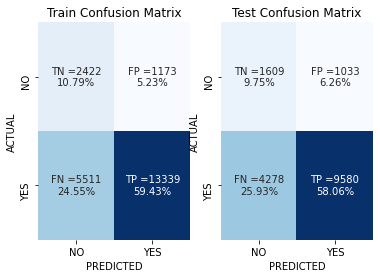

In [317]:
from sklearn.metrics import confusion_matrix
best_t = find_best_t(tr_thres, tr_tpr, tr_fpr)

cm_train = confusion_matrix(y_train, predict_with_best_t(y_train_prob, best_t))   #calculating confusion matrix for test and train
cm_test = confusion_matrix(y_test, predict_with_best_t(y_test_prob, best_t))             

## Matrix Formatting ##

#https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
def get_label(cm):
    group_names = ['TN =','FP =','FN =','TP =']       #storing group names required for labelling the matrix
    group_counts = [value for value in cm.flatten()]  #storing group counts
    group_percentages = ["{0:.2%}".format(value) for value in cm.flatten()/np.sum(cm)] #calculating the percentage for each group with two decimals

    labels = [f"{v1}{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_counts,group_percentages)] #storing the label values
    labels = np.asarray(labels).reshape(2,2)
    
    return labels


ax= plt.subplot(1,2,1);
sns.heatmap(cm_train, annot=get_label(cm_train),fmt='',cmap='Blues',cbar=False,ax=ax);

# labels, title and ticks
ax.set_xlabel('PREDICTED');ax.set_ylabel('ACTUAL'); 
ax.set_title('Train Confusion Matrix');
ax.xaxis.set_ticklabels(['NO','YES']); 
ax.yaxis.set_ticklabels(['NO','YES']);

ax= plt.subplot(1,2,2);
sns.heatmap(cm_test, annot=get_label(cm_test),fmt='',cmap='Blues',cbar=False,ax=ax);

# labels, title and ticks
ax.set_xlabel('PREDICTED');ax.set_ylabel('ACTUAL'); 
ax.set_title('Test Confusion Matrix');
ax.xaxis.set_ticklabels(['NO','YES']); 
ax.yaxis.set_ticklabels(['NO','YES']);



the maximum value of tpr*(1-fpr) 0.4361246942592681 for threshold 0.521


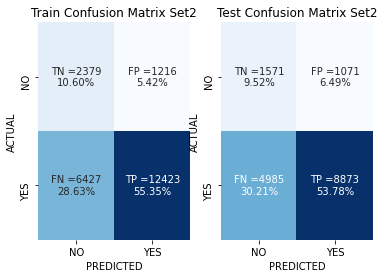

In [319]:
#same code for set2
best_t_s2 = find_best_t(tr_thres_s2, tr_tpr_s2, tr_fpr_s2)

cm_train_s2 = confusion_matrix(y_train, predict_with_best_t(y_train_prob_s2, best_t_s2))   #calculating confusion matrix for test and train
cm_test_s2 = confusion_matrix(y_test, predict_with_best_t(y_test_prob_s2, best_t_s2))             

## Matrix Formatting ##

ax= plt.subplot(1,2,1);
sns.heatmap(cm_train_s2, annot=get_label(cm_train_s2),fmt='',cmap='Blues',cbar=False,ax=ax);

# labels, title and ticks
ax.set_xlabel('PREDICTED');ax.set_ylabel('ACTUAL'); 
ax.set_title('Train Confusion Matrix Set2');
ax.xaxis.set_ticklabels(['NO','YES']); 
ax.yaxis.set_ticklabels(['NO','YES']);

ax= plt.subplot(1,2,2);
sns.heatmap(cm_test_s2, annot=get_label(cm_test_s2),fmt='',cmap='Blues',cbar=False,ax=ax);

# labels, title and ticks
ax.set_xlabel('PREDICTED');ax.set_ylabel('ACTUAL'); 
ax.set_title('Test Confusion Matrix Set2');
ax.xaxis.set_ticklabels(['NO','YES']); 
ax.yaxis.set_ticklabels(['NO','YES']);


# 2. Displaying Top 20 Features

In [223]:
features=[]                                #declaring an empty list for storing the features

vec = CountVectorizer(min_df = 4, ngram_range = (1,4),max_features=5000) #initializing count vectorizer for storing text with 5000 features
vec.fit(X_train['essay'])                  #fitting training data for essay
features.extend(vec.get_feature_names())   #storing the features in the list

columns = ['school_state','teacher_prefix','project_grade_category','clean_categories','clean_subcategories'] #storing the column names of the categorical columns in the dataframe

vectorizer = CountVectorizer()             #initializing count vectorizer

for i in columns:                          #for each column
    vectorizer.fit(X_train[i])             #fit train data for that column
    features.extend(vectorizer.get_feature_names()) #store the feature names for categorical data

features.append('teacher_number_of_previously_posted_projects') #appending the numerical columns to the feature set.
features.append('price')

In [244]:
clf = MultinomialNB(alpha =1,class_prior =[0.5,0.5])
clf.fit(X_tr,y_train)

x0 = clf.feature_log_prob_[0]     #storing the indexes for the top 20 log probability scores for negative class label
x1 = clf.feature_log_prob_[1]     #storing the indexes for the top 20 log probability scores for positive class label

neg_idx = x0.argsort()[::-1][:20] #https://stackoverflow.com/questions/16486252/is-it-possible-to-use-argsort-in-descending-order
pos_idx = x1.argsort()[::-1][:20] 

top_negative_features = []        #list for storing top 20 negative features
top_positive_features = []        #list for storing top 20 negative features

for i in neg_idx:                 #for each index append the feature name to the list
    top_negative_features.append(features[i])

print('Top 20 Features helpful in determining negative Class label :\n')
print(top_negative_features,'\n')

for j in pos_idx:                 #for each index append the feature name to the list
    top_positive_features.append(features[j])

print('Top 20 Features helpful in determining positive Class label :\n')
print(top_positive_features)


Top 20 Features helpful in determining negative Class label :

['students', 'school', 'learning', 'my', 'classroom', 'not', 'learn', 'help', 'they', 'my students', 'the', 'many', 'nannan', 'need', 'we', 'work', 'year', 'come', 'reading', 'able'] 

Top 20 Features helpful in determining positive Class label :

['students', 'school', 'my', 'classroom', 'learning', 'the', 'not', 'they', 'learn', 'my students', 'help', 'many', 'nannan', 'reading', 'work', 'we', 'need', 'use', 'day', 'able']


<h1>3. Summary</h1>

In [270]:
d = {'Vectorizer':['BOW','TFIDF'],'Model':['Naive Nayes','Naive Nayes'],'Hyper parameter':[best_alpha,best_alpha],'AUC':[auc(te_fpr,te_tpr),auc(te_fpr_s2,te_tpr_s2)]}
summary = pd.DataFrame(data = d) #creating a dataframe and storing the required data

#using tabulate for displaying the data in the desired format. source:stackoverflow.com
from tabulate import tabulate  
pdtabulate=lambda df:tabulate(summary,headers='keys',tablefmt='psql',showindex=False)

print(pdtabulate(summary))

+--------------+-------------+-------------------+----------+
| Vectorizer   | Model       |   Hyper parameter |      AUC |
|--------------+-------------+-------------------+----------|
| BOW          | Naive Nayes |                 1 | 0.698641 |
| TFIDF        | Naive Nayes |                 1 | 0.660593 |
+--------------+-------------+-------------------+----------+


Reference: www.appliedaicourse.com